In [3]:
from paths import DATA_DIR, CKPT_FOLDER, PROJECT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv

import anndata
import pandas as pd
import scvelo as scv
import cellrank as cr


from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.datamodules.sc_datamodule import scDataModule

from notebooks.utils import (standardize_adata,
                             add_keys_to_dict,
                             real_reconstructed_cells_adata,
                             add_velocity_to_adata, 
                             compute_velocity_projection, 
                             compute_trajectory, 
                             decode_trajectory)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[rank: 0] Global seed set to 0


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
CELLTYPE_ANNOTATION = {0: 'Acinar',
                         1: 'Alpha',
                         2: 'Beta',
                         3: 'Delta',
                         4: 'Ductal',
                         5: 'Epsilon',
                         6: 'Fev+ Alpha',
                         7: 'Fev+ Beta',
                         8: 'Fev+ Delta',
                         9: 'Fev+ Epsilon',
                         10: 'Fev+ Pyy',
                         11: 'Multipotent',
                         12: 'Ngn3 High early',
                         13: 'Ngn3 High late',
                         14: 'Ngn3 low EP',
                         15: 'Tip',
                         16: 'Trunk'}

## Read anndata files

First, read the latent space anndata and plot the results

In [6]:
adata_latent_vae = sc.read_h5ad(DATA_DIR / "pancreas" / "flat" / "pancreas_lib.h5ad")
adata_latent_flat = sc.read_h5ad(DATA_DIR / "pancreas" / "flat" / "pancreas_flat_lib.h5ad")

In [7]:
adata_latent_vae.obs["celltype"] = [CELLTYPE_ANNOTATION[i] for i in adata_latent_vae.obs["celltype"]]
adata_latent_flat.obs["celltype"] = [CELLTYPE_ANNOTATION[i] for i in adata_latent_flat.obs["celltype"]]

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


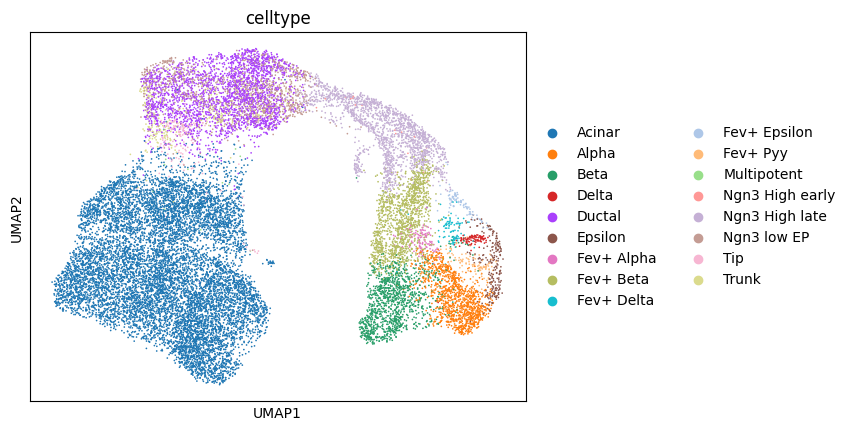

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


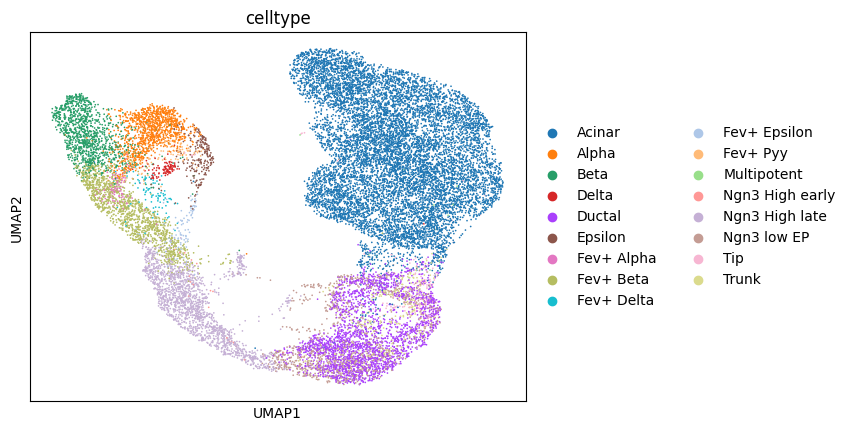

In [8]:
sc.pl.umap(adata_latent_vae, color="celltype")
sc.pl.umap(adata_latent_flat, color="celltype")

## Initialize module

In [9]:
datamodule_kwargs_vae = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/pancreas/flat/pancreas_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/pancreas/flat/pancreas_flat_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

Velocity field network

In [10]:
net_hparams = {"dim": datamodule_vae.dim,
                "w": 64,
                "time_varying": True}

net_vae = MLP(**net_hparams).to(device)
net_flat = MLP(**net_hparams).to(device)

CFM model 

In [11]:
cfm_kwargs = {'ot_sampler': 'exact', 
                   'sigma': 0.1, 
                   'use_real_time': False, 
                   'lr': 0.001, 
                   'antithetic_time_sampling': True}

cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)

In [12]:
cfm_vae.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "pancreas" / "best_cfm_model_pancreas.ckpt")["state_dict"])
cfm_flat.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "pancreas" / "best_cfm_model_flat_pancreas.ckpt")["state_dict"])

<All keys matched successfully>

**Add velocities to anndata and plot them onto the umap and pca**

In [13]:
add_velocity_to_adata(adata_latent_vae, cfm_vae, device)
add_velocity_to_adata(adata_latent_flat, cfm_flat, device)

### Flat latent space 

In [14]:
vk_flat = cr.kernels.VelocityKernel(adata_latent_flat,
                              xkey="X_latents", 
                              vkey="velocity")
vk_flat.compute_transition_matrix()
adata_latent_flat.uns["velocity_graph"] = vk_flat.transition_matrix

  0%|          | 0/20480 [00:00<?, ?cell/s]

  0%|          | 0/20480 [00:00<?, ?cell/s]

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


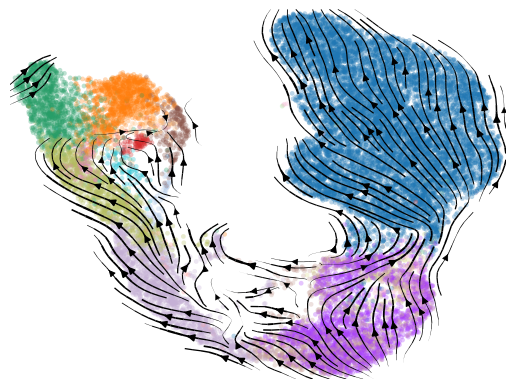

In [15]:
scv.pl.velocity_embedding_stream(adata_latent_flat, basis="umap", color="celltype", title="", smooth=0.5, legend_loc='none')

In [16]:
g_flat = cr.estimators.GPCCA(vk_flat)
g_flat.compute_schur(n_components=10)
g_flat.compute_macrostates(n_states=9, cluster_key="celltype")

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


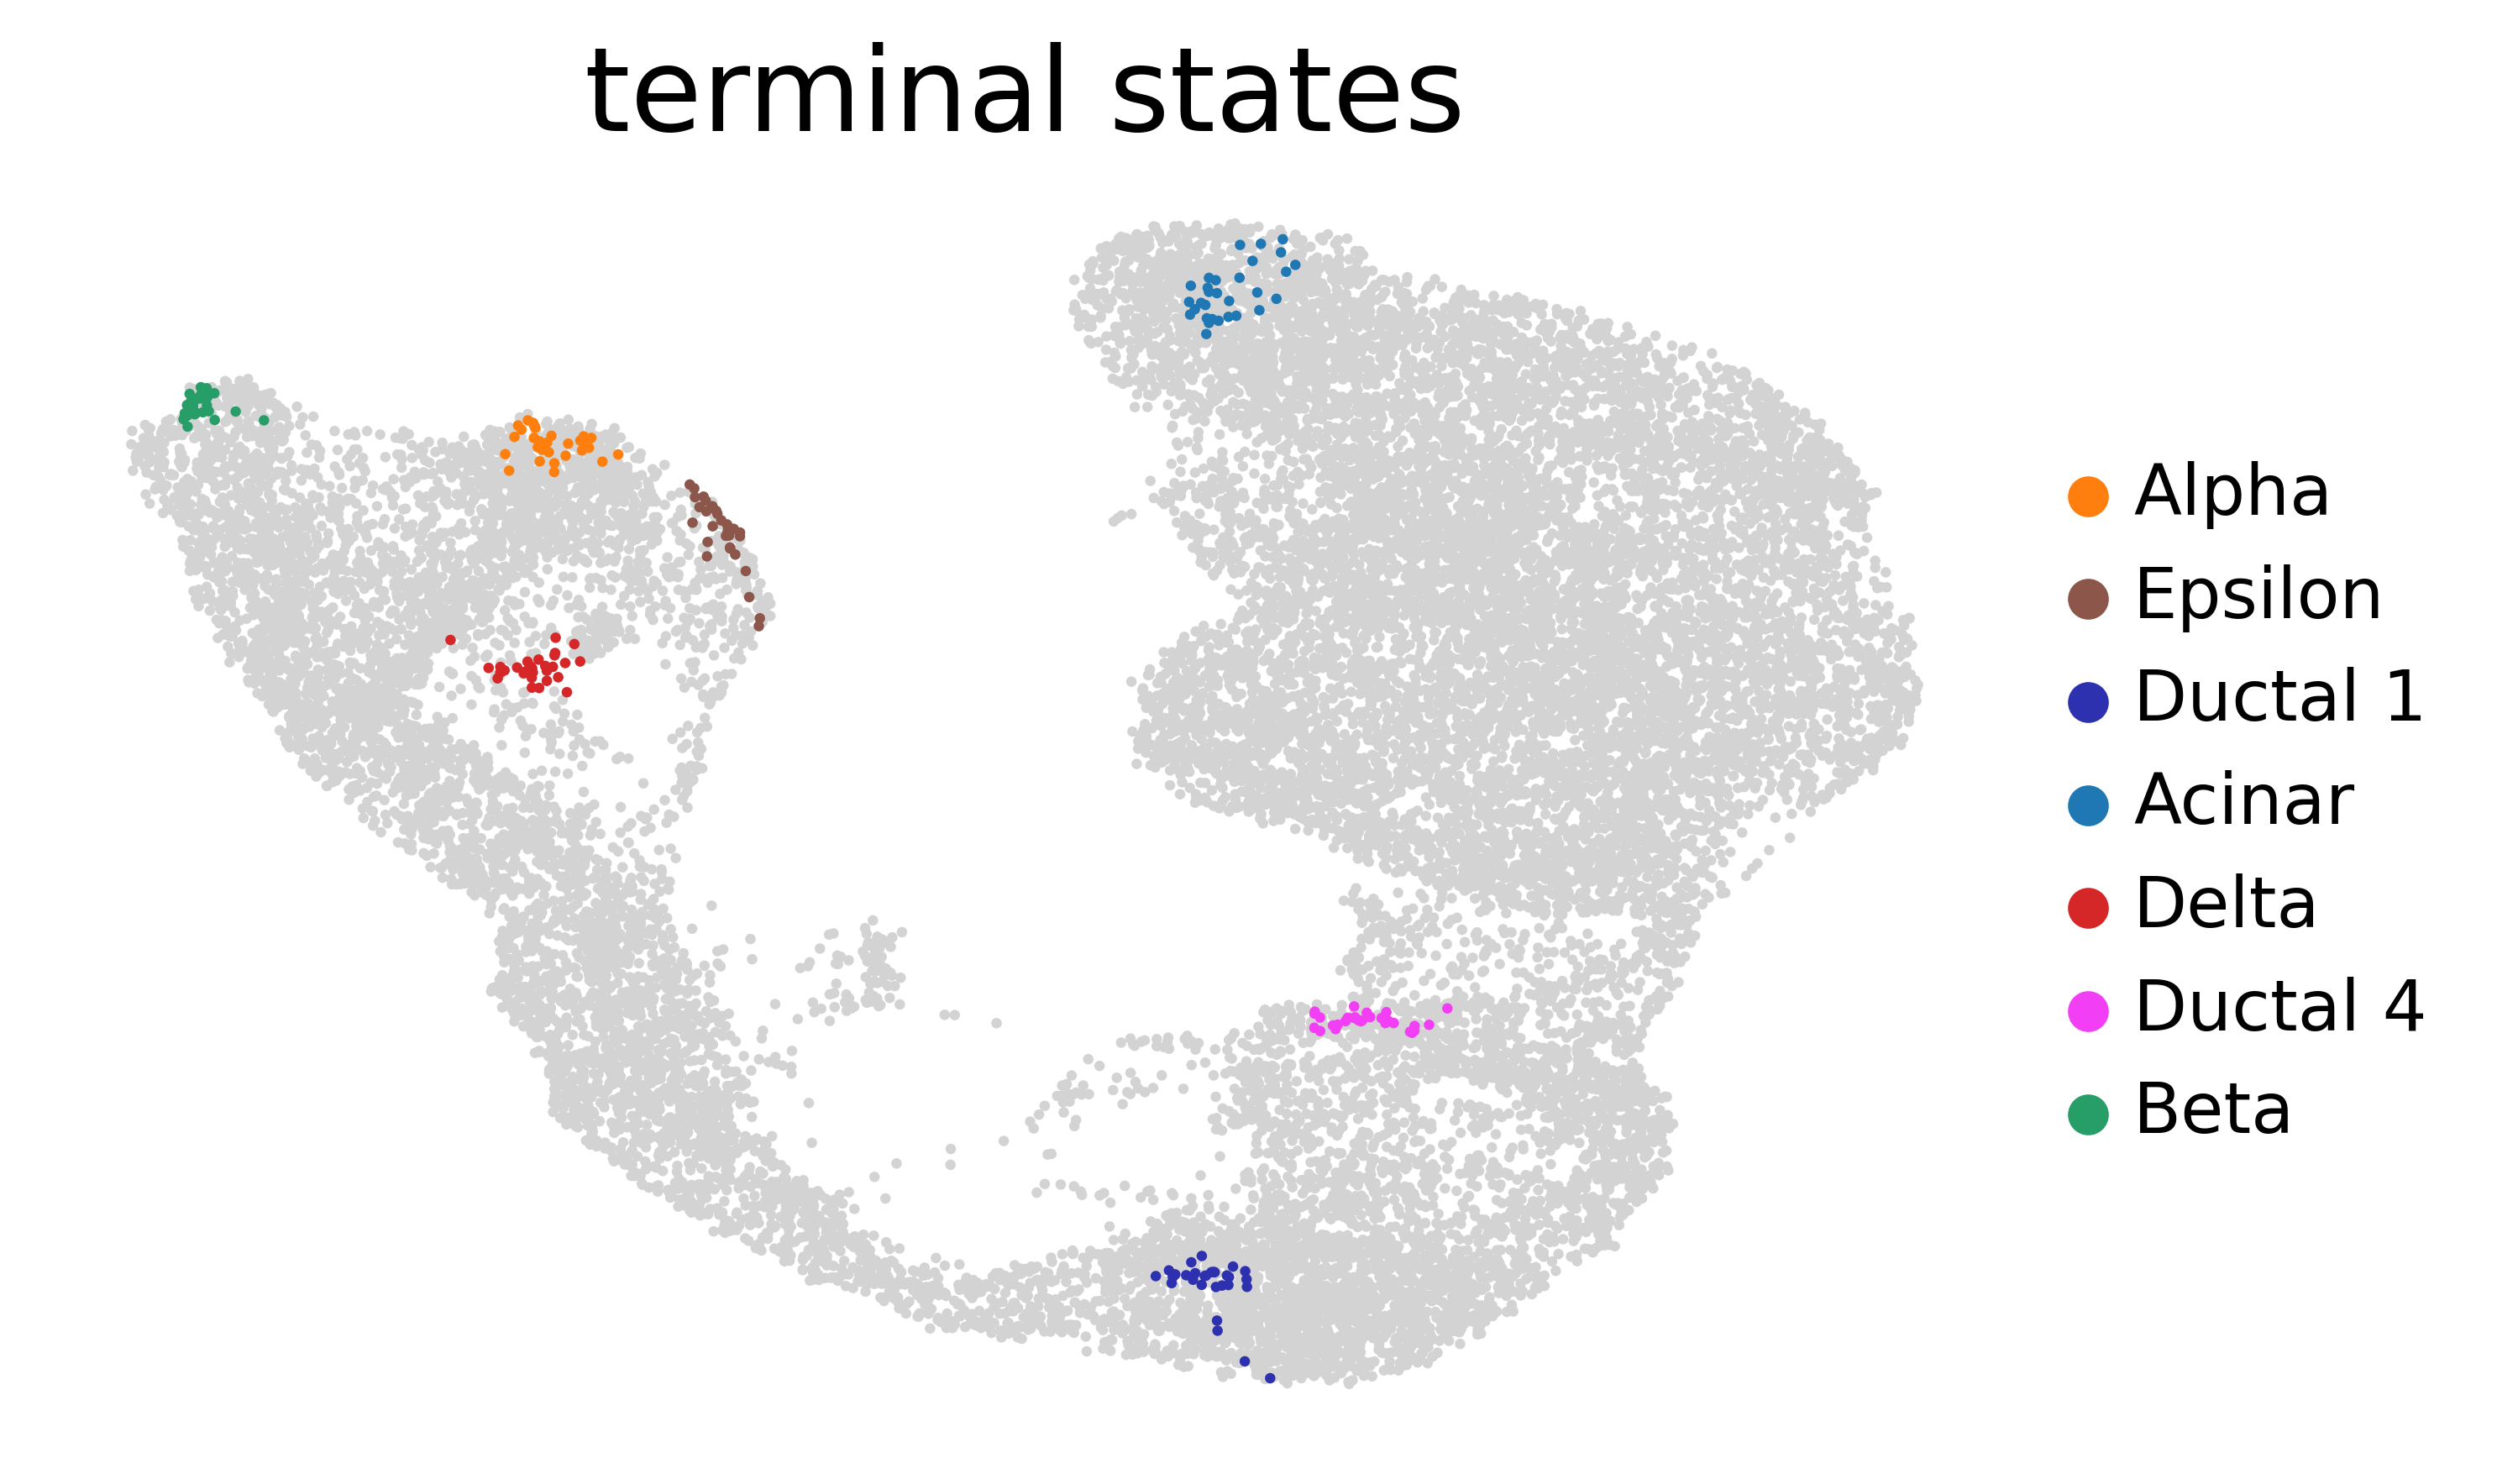

In [17]:
g_flat.compute_terminal_states(method="top_n", n_states=7)
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g_flat.plot_terminal_states(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [31]:
adata_latent_flat.layers["Ms"] = adata_latent_flat.layers["X_latents"].copy()
scv.tl.velocity_confidence(adata_latent_flat)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [38]:
np.mean(adata_latent_flat.obs["velocity_confidence"])

0.9417372019241157

### Normal latent space

In [19]:
vk_vae = cr.kernels.VelocityKernel(adata_latent_vae,
                              xkey="X_latents", 
                              vkey="velocity")
vk_vae.compute_transition_matrix()
adata_latent_vae.uns["velocity_graph"] = vk_vae.transition_matrix

  0%|          | 0/20480 [00:00<?, ?cell/s]

  0%|          | 0/20480 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


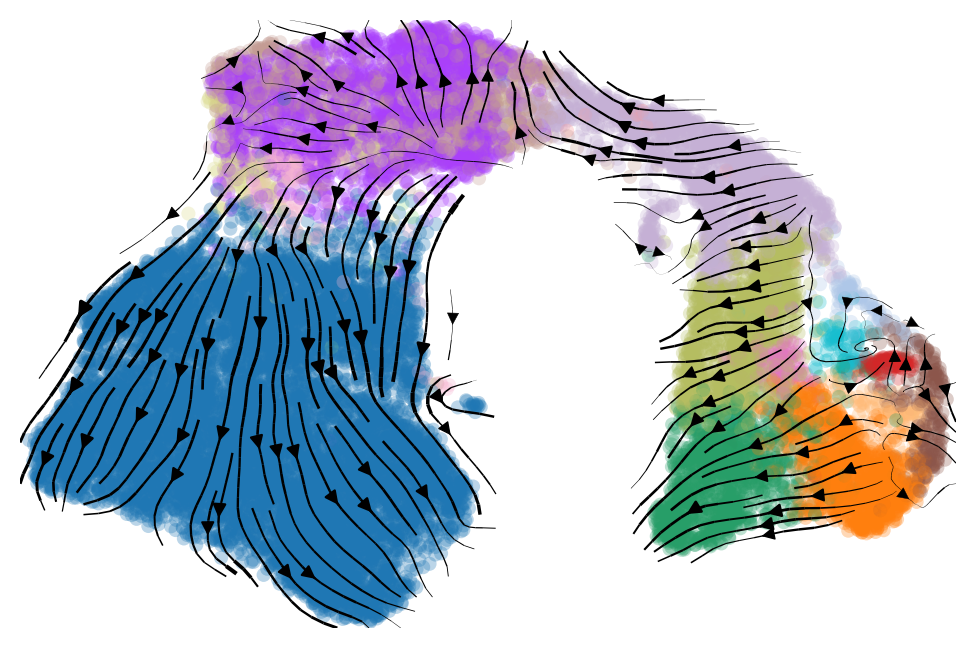

In [20]:
scv.pl.velocity_embedding_stream(adata_latent_vae, basis="umap", color="celltype", title="", smooth=0.5, legend_loc='none')

In [25]:
g_vae = cr.estimators.GPCCA(vk_vae)
g_vae.compute_schur(n_components=20)
g_vae.compute_macrostates(n_states=20, cluster_key="celltype")

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


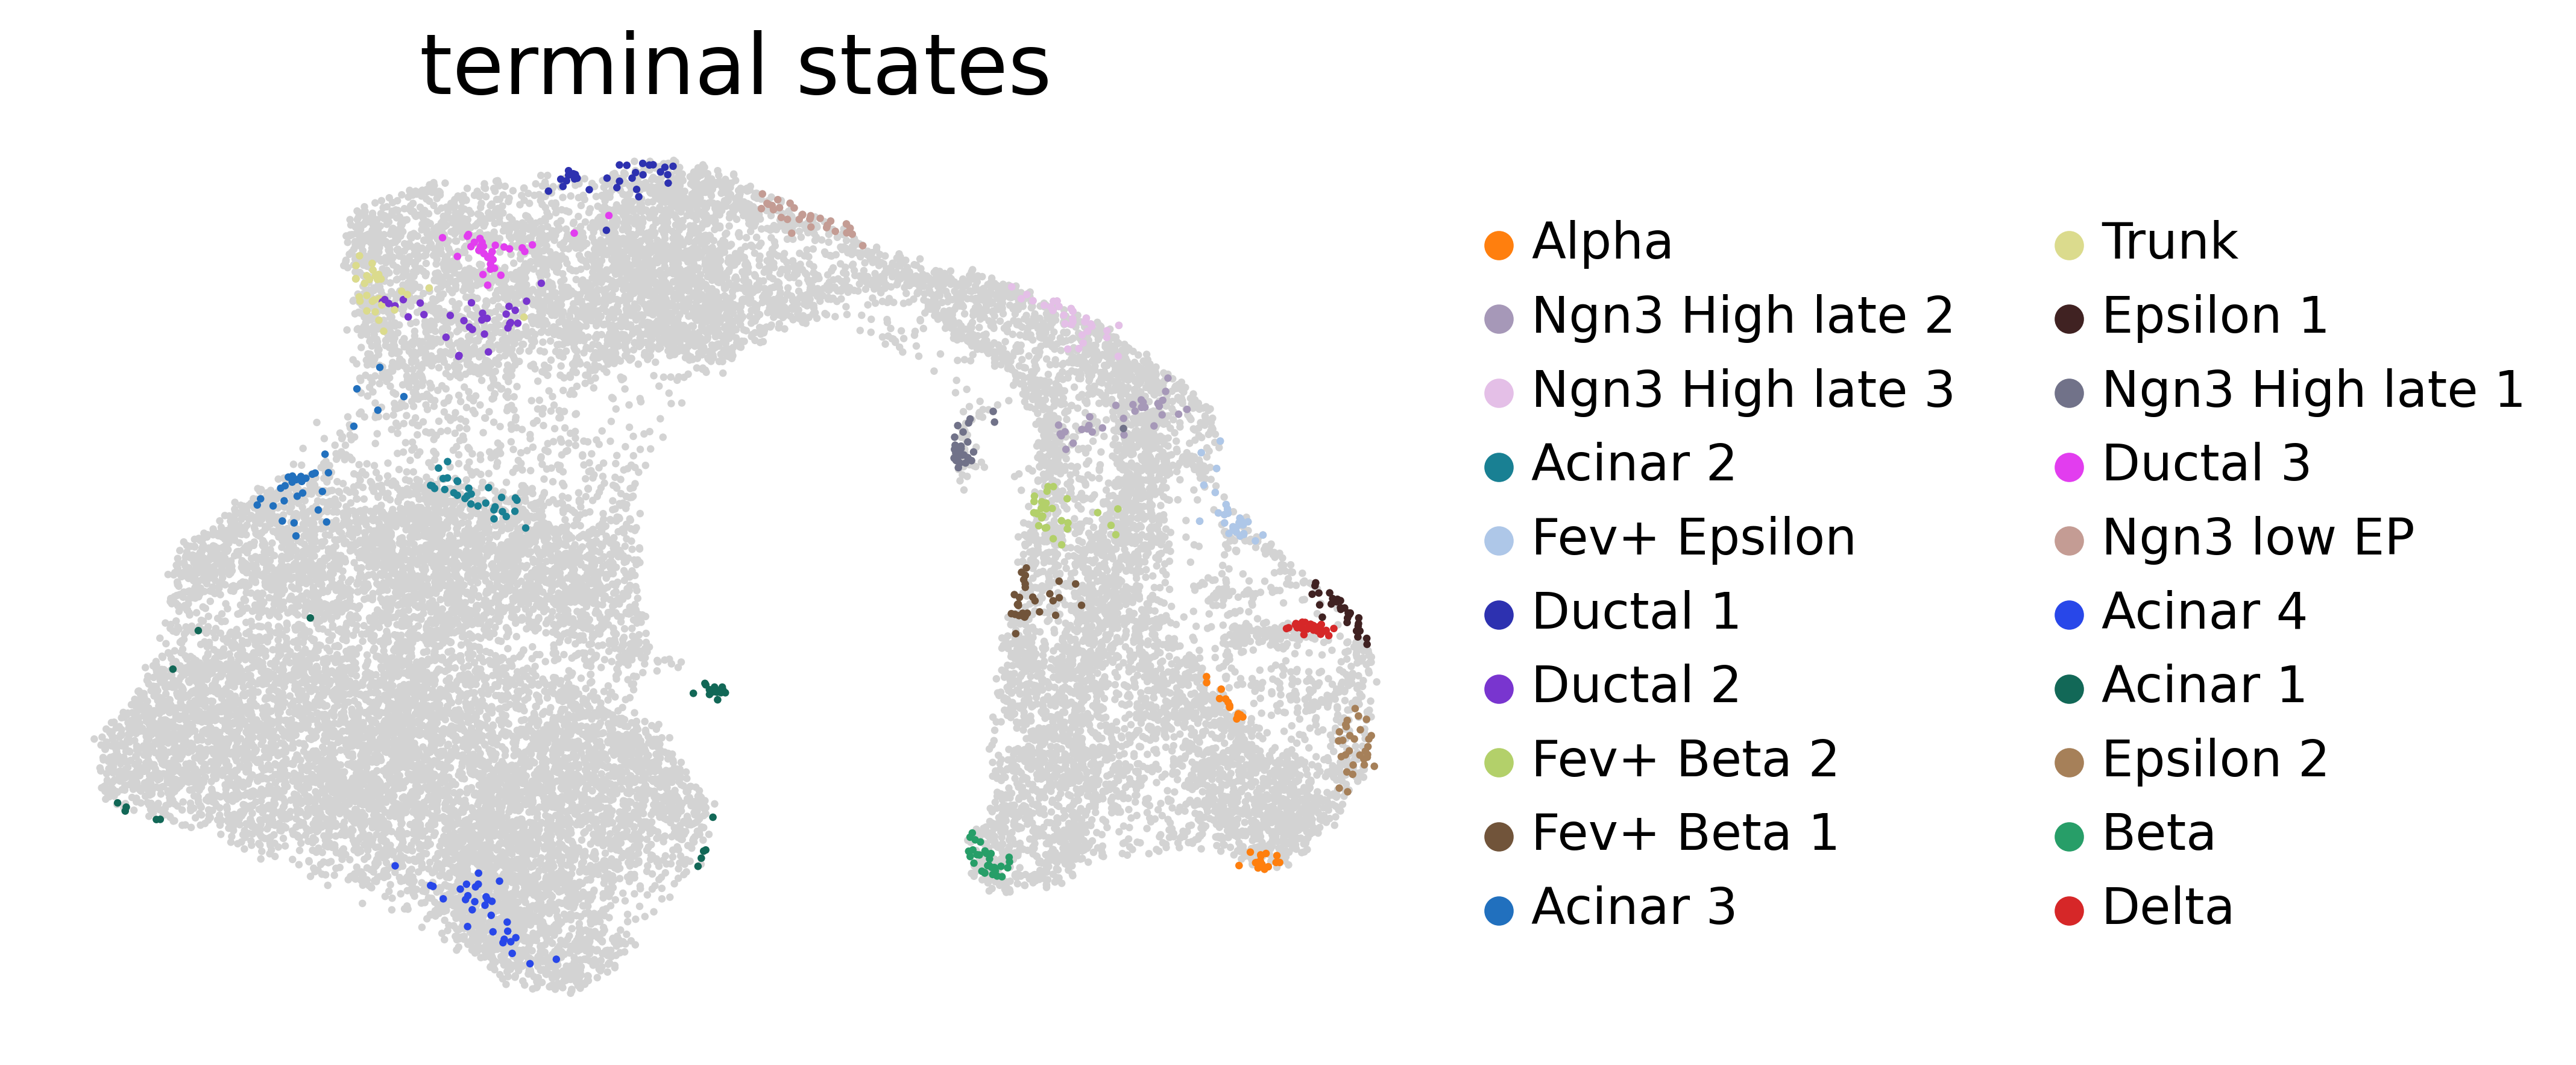

In [30]:
g_vae.compute_terminal_states(method="top_n", n_states= 20)
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g_vae.plot_terminal_states(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [34]:
adata_latent_vae.layers["Ms"] = adata_latent_vae.layers["X_latents"].copy()
scv.tl.velocity_confidence(adata_latent_vae)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [36]:
adata_latent_vae.obs

,experimental_time,celltype,log_library_size,terminal_states,terminal_states_probs,velocity_length,velocity_confidence,velocity_confidence_transition
0,0.0,Acinar,7.454015,NaN,0.937232,3.66,0.991916,0.712506
1,1.0,Alpha,8.181149,NaN,0.862059,2.18,0.895772,0.526334
2,0.0,Ductal,7.703272,NaN,0.566117,6.03,0.956561,0.669825
3,0.0,Fev+ Beta,7.850375,NaN,0.589791,4.55,0.763249,0.821883
4,0.0,Alpha,8.141107,NaN,0.594902,2.24,0.909045,0.813473
...,...,...,...,...,...,...,...,...
20475,0.0,Ngn3 low EP,7.700648,NaN,0.676632,2.72,0.811959,0.751091
20476,0.0,Tip,7.549705,NaN,0.886266,3.92,0.985560,0.900691
20477,1.0,Acinar,7.711196,NaN,0.779973,4.64,0.850790,0.764529
20478,1.0,Alpha,7.937888,NaN,0.630946,2.35,0.943710,0.750793


In [39]:
np.mean(adata_latent_vae.obs["velocity_confidence"])

0.9188959777280615